# Set up

In [ ]:
#Common Imports
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import pickle
from tensorflow import keras

#Data Visualization
import matplotlib.pyplot as plt

#Model Architecture
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Dense

# Model Training
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

#LabelEncoder
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Data Preparation

In [ ]:
# Constants
BATCH_SIZE = 32 # number of samples per gradient update
EPOCHS = 30 # number of epoch to train models how much

# Hyperparameters
LEARNING_RATE = 1e-3 # learning rate for the optimizer

# Model training
LOSS = 'mse'
METRICS = ['mae']

Datasets Path

In [ ]:
# Dataset Paths
file_path = "Transaction_Data.csv"

Check Configuration

In [ ]:
# Print configuration to check our setting before
print(f"Batch Size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Loss: {LOSS}")
print(f"Metrics: {METRICS}")
print(f"Dataset Path: {file_path}")


Batch Size: 32
Epochs: 30
Learning Rate: 0.001
Loss: mse
Metrics: ['mae']
Dataset Path: Transaction_Data.csv


Load Dataset

In [ ]:
data = pd.read_csv(file_path)
data['date'] = pd.to_datetime(data['date'])

Check Dataset

In [ ]:
# Display first few rows of the dataset to check our Dataset we have
print("\nSample Data:")
print(data.head())


Sample Data:
  user_id                date        category  amount     type
0  User_1 2024-09-01 12:04:00    Food & Drink   50000  Expense
1  User_1 2024-09-02 14:43:00  Transportation   50000  Expense
2  User_1 2024-09-03 10:26:00         Digital   52000  Expense
3  User_1 2024-09-03 16:26:00  Transportation   40000  Expense
4  User_1 2024-09-04 08:22:00          Income  200000   Income


In [ ]:
# Dataset summary, check our dataset type for each column
print("\nDataset Summary:")
print(data.info())


Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11763 entries, 0 to 11762
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   11763 non-null  object        
 1   date      11763 non-null  datetime64[ns]
 2   category  11763 non-null  object        
 3   amount    11763 non-null  int64         
 4   type      11763 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 459.6+ KB
None


# Data Preprocessing

In [ ]:
#Make a preprocessing data like do labeling in category and scalarizer 0-1 in amount column
def preprocess_data(data, le_category=None, scaler=None):
    data['month'] = data['date'].dt.month
    data['day'] = data['date'].dt.day

    # Encode 'category'
    if le_category is None:
        le_category = LabelEncoder()
        data['category_encoded'] = le_category.fit_transform(data['category'])
    else:
        data['category_encoded'] = le_category.transform(data['category'])

    # Scale 'amount'
    if scaler is None:
        scaler = MinMaxScaler()
        data['amount_scaled'] = scaler.fit_transform(data[['amount']])
    else:
        data['amount_scaled'] = scaler.transform(data[['amount']])

    return data, le_category, scaler


Filter Expense Data Only For Training

In [ ]:
# Filter only 'Expense' data in column type
filtered_data = data[data['type'] == 'Expense']
filtered_data, le_category, scaler = preprocess_data(filtered_data)

<ipython-input-8-ed3cd3ba1450>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['month'] = data['date'].dt.month
<ipython-input-8-ed3cd3ba1450>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['day'] = data['date'].dt.day
<ipython-input-8-ed3cd3ba1450>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Setup X and Y as input and output

In [ ]:
# Prepare features and labels
X = filtered_data[['category_encoded', 'month', 'day']].values
y = filtered_data['amount_scaled'].values

In [ ]:
print("\nPreprocessed Data:")
print(filtered_data.head())


Preprocessed Data:
  user_id                date        category  amount     type  month  day  \
0  User_1 2024-09-01 12:04:00    Food & Drink   50000  Expense      9    1   
1  User_1 2024-09-02 14:43:00  Transportation   50000  Expense      9    2   
2  User_1 2024-09-03 10:26:00         Digital   52000  Expense      9    3   
3  User_1 2024-09-03 16:26:00  Transportation   40000  Expense      9    3   
5  User_1 2024-09-04 08:57:00  Transportation   50000  Expense      9    4   

   category_encoded  amount_scaled  
0                 3       0.005069  
1                 6       0.005069  
2                 0       0.005274  
3                 6       0.004045  
5                 6       0.005069  


#Build Model

Model Architecture

In [ ]:
#Model Arhitecture with sequential model
def build_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_shape,)),

        # Dense Block 1
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer='l2'),
        tf.keras.layers.Dropout(0.3),

        # Dense Block 2
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2'),
        tf.keras.layers.Dropout(0.2),

        # Dense Block 3
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer='l2'),
        tf.keras.layers.Dropout(0.1),

        # Output Layer
        tf.keras.layers.Dense(1, activation='linear')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss=LOSS,
                  metrics=METRICS)
    return model

model = build_model(X.shape[1])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,241 (165.00 KB)

 Trainable params: 42,241 (165.00 KB)

 Non-trainable params: 0 (0.00 B)

Plot Function to show The Progress

In [ ]:
#Visualization Training Function to monitoring the progress
def plot_training(history):
    """
    Plot training loss and metrics over epochs.
    """
    history_dict = history.history
    plt.figure(figsize=(10, 6))
    plt.plot(history_dict['loss'], label='Training Loss')
    plt.plot(history_dict['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

#Train The Model

In [ ]:
#Setup Early stop if the progress is flat
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
history = model.fit(X, y,
                    validation_split=0.2,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 2.0648 - mae: 0.3126 - val_loss: 0.7384 - val_mae: 0.0375
Epoch 2/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6185 - mae: 0.0368 - val_loss: 0.3729 - val_mae: 0.0405
Epoch 3/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3158 - mae: 0.0290 - val_loss: 0.2048 - val_mae: 0.0407
Epoch 4/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1726 - mae: 0.0270 - val_loss: 0.1185 - val_mae: 0.0409
Epoch 5/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0980 - mae: 0.0257 - val_loss: 0.0719 - val_mae: 0.0423
Epoch 6/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0570 - mae: 0.0237 - val_loss: 0.0461 - val_mae: 0.0423
Epoch 7/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0350 - mae: 0.0239 - val_loss: 0.0315 - val_mae: 0.0428
Epoch 8/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0225 - mae: 0.0250 - val_loss: 0.0232 - val_mae: 0.0410
Epoch 9/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

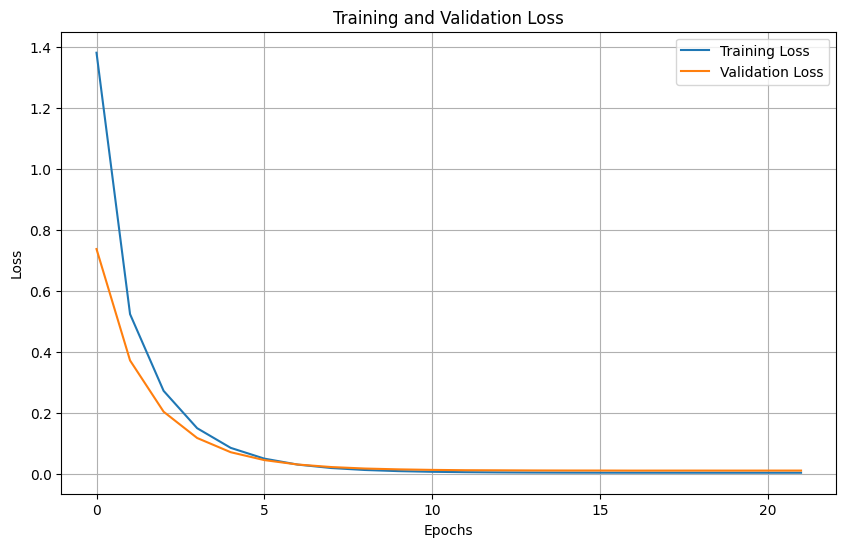

In [ ]:
plot_training(history)

Evaluate

In [ ]:
loss, mae = model.evaluate(X, y, verbose=0)
print(f"\nModel Evaluation:\n - Loss (MSE): {loss:.4f}\n - MAE: {mae:.4f}")


Model Evaluation:
 - Loss (MSE): 0.0061
 - MAE: 0.0300


Saved The model to next Progress Deployment

In [ ]:
# Save the trained model
model.save('budget_suggestion_model.keras')

# Save preprocessors
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le_category, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Model and preprocessors saved successfully.")


Model and preprocessors saved successfully.


# Result Recommendation Budgeting

In [ ]:
#Test Generate Function Recommendation in Model.py
# Total Expense * each category percent for total Expense they do
# For Example Total Expense User_1 in period 3 month = 3.500.000
# and for each category he have 3 category did he use in transaction in 3 month period
# Food = 39.56% transport = 31.56 others = 28.88 and will do recommendation each persent * total expense
# and in the next the budgeting will different depend history he doing in transactions.
def generate_recommendations(data, user_id_col='user_id', categories_col='category_encoded', amount_col='amount', le_category=None):
    """
    Generate dynamic budget recommendations based on user spending patterns over all available months.
    """
    # Group data by user and category to sum expenses
    user_expenses = data.groupby([user_id_col, categories_col])[amount_col].sum().reset_index()

    # Calculate total expenses per user
    total_expenses = user_expenses.groupby(user_id_col)[amount_col].sum()

    recommendations = {}
    for user, total in total_expenses.items():
        # User specific data
        user_data = user_expenses[user_expenses[user_id_col] == user]

        # Months of data available for the user
        num_months = data[data[user_id_col] == user]['month'].nunique()

        # Calculate average monthly expenses
        monthly_average = total / num_months if num_months else 0

        # Calculate category distribution and budget recommendation
        category_distribution = user_data.set_index(categories_col)[amount_col] / total
        budget_recommendation = {
            le_category.inverse_transform([int(category)])[0]: round(percent * monthly_average, 2)
            for category, percent in category_distribution.items()
        }
        recommendations[user] = budget_recommendation

    return recommendations

In [ ]:
# Example of using this function
# Call by user_id
budget_recommendations = generate_recommendations(filtered_data,
                                                  user_id_col='user_id',
                                                  categories_col='category_encoded',
                                                  amount_col='amount',
                                                  le_category=le_category)

print("Budget Recommendations:")
print(budget_recommendations)

Budget Recommendations:
{'User_1': {'Digital': 52000.0, 'Food & Drink': 600000.0, 'Transportation': 396666.67}, 'User_10': {'Digital': 50000.0, 'Entertainment': 317833.33, 'Food & Drink': 1038500.0, 'Transportation': 296666.67, 'Utilities': 300000.0}, 'User_11': {'Education': 25000.0, 'Food & Drink': 456666.67, 'Transportation': 540000.0}, 'User_12': {'Education': 185000.0, 'Food & Drink': 175666.67, 'Transportation': 52000.0}, 'User_13': {'Education': 120000.0, 'Food & Drink': 1120333.33, 'Transportation': 226666.67}, 'User_14': {'Food & Drink': 1765000.0, 'Transportation': 216666.67, 'Utilities': 200000.0}, 'User_15': {'Food & Drink': 2474333.33, 'Health': 223000.0, 'Transportation': 373666.67, 'Utilities': 328000.0}, 'User_16': {'Food & Drink': 2052333.33, 'Health': 500000.0, 'Transportation': 516666.67, 'Utilities': 170333.33}, 'User_17': {'Food & Drink': 1649000.0, 'Health': 300000.0, 'Transportation': 516666.67, 'Utilities': 95000.0}, 'User_18': {'Education': 2000000.0, 'Food & D

In [ ]:
# Convert recommendations to a DataFrame for visualization
recommendations_list = []
for user, categories in budget_recommendations.items():
    for category, budget in categories.items():
        recommendations_list.append({'User': user, 'Category': category, 'Budget Recommendation': budget})

recommendations_df = pd.DataFrame(recommendations_list)
print("Budget Recommendations:")
print(recommendations_df)

Budget Recommendations:
        User        Category  Budget Recommendation
0     User_1         Digital               52000.00
1     User_1    Food & Drink              600000.00
2     User_1  Transportation              396666.67
3    User_10         Digital               50000.00
4    User_10   Entertainment              317833.33
..       ...             ...                    ...
295   User_8       Utilities             1200000.00
296   User_9   Entertainment              134166.67
297   User_9    Food & Drink             1524000.00
298   User_9  Transportation               67000.00
299   User_9       Utilities              200000.00

[300 rows x 3 columns]


In [ ]:
# Filter recommendations for a specific user
user_to_display = 'User_59'  # Ganti dengan user yang ingin ditampilkan
filtered_recommendations_df = recommendations_df[recommendations_df['User'] == user_to_display]

# Display filtered recommendations
print(f"Budget Recommendations for {user_to_display}:")
print(filtered_recommendations_df)


Budget Recommendations for User_59:
        User        Category  Budget Recommendation
264  User_59       Education             2083333.33
265  User_59   Entertainment             8162333.33
266  User_59    Food & Drink             4818000.00
267  User_59          Health             2567333.33
268  User_59          Others             2986000.00
269  User_59  Transportation             2714000.00


In [ ]:
import plotly.graph_objects as go

# Buat tabel dengan Plotly
def plotly_table(dataframe):
    header_values = list(dataframe.columns)
    cell_values = [dataframe[col].tolist() for col in dataframe.columns]

    fig = go.Figure(data=[go.Table(
        header=dict(
            values=header_values,
            fill_color='paleturquoise',
            align='left'
        ),
        cells=dict(
            values=cell_values,
            fill_color='lavender',
            align='left')
    )])

    fig.show()

# Panggil fungsi dengan DataFrame kamu
plotly_table(recommendations_df)